# Overview of Movie Popularity Prediction

In this project, I aim to predict whether a movie is going to perform well on Amazon Prime Video with python, specifically I want to predict the cumulated view time per day of each film based on labeled data. 

* Lots of Missing values
  Among the 10 numerical features (not include video_id and release_year), 4 features have over 25% of missing data
* Weighted categorical position, weighted horizontal position and imbd_votes are highly predictive features of popular movies.

# Pre Load packages 


In [14]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings('ignore')

# Pre Load data 

'Video_id' is defined as the index of each sample. 'cvt_per_day' is the metric, the rest of 14 columns are all characteristic features (numeric & categorical) of each video.

In [15]:
TV = pd.read_table('data/TVdata.txt', sep = ',', header=0, lineterminator = '\n')
TV.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [16]:
print ('Number of rows: ' + str(TV.shape[0]))
print ('Number of columns: ' + str(TV.shape[1]))

Number of rows: 4226
Number of columns: 16



# 1 : Data Exploration

## 1.1 Exclude erroneous data 
Each video should only appear once in the list, duplicated video will be removed.

In [17]:
# check duplicated entry
if sum(TV['video_id'].duplicated()) == 0:
    print ('There is no duplicated entry (video_id based).')

There is no duplicated entry (video_id based).


## 1.2 Understand the numerical features
### 1.2.1 Overview 
Note: video_id, release_year are not numerical features although they are represented by numbers.

In [18]:
print (TV.drop(['video_id', 'release_year'],axis=1).describe(percentiles = [.1, .25, .5, .75, .95]))
print ((TV == 0).sum())
print (TV.dtypes)

       cvt_per_day  weighted_categorical_position  \
count     4226.000                       4226.000   
mean      4218.630                          7.783   
std      13036.080                          6.134   
min          2.188                          1.000   
10%        141.985                          3.000   
25%        351.169                          4.000   
50%       1193.500                          6.000   
75%       3356.789                          9.000   
95%      14692.834                         22.000   
max     307127.606                         41.000   

       weighted_horizontal_position  imdb_votes        budget     boxoffice  \
count                      4226.000    4226.000      4226.000      4226.000   
mean                         28.104    6462.924   2150743.439   2536338.472   
std                          11.864   31596.007   7176604.483   8243516.266   
min                           1.000       0.000         0.000         0.000   
10%                  

Among the 10 numerical features (not include video_id and release_year), 4 features have over 25% of missing data: budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

###  1.2.2 cvt_per_day feature 

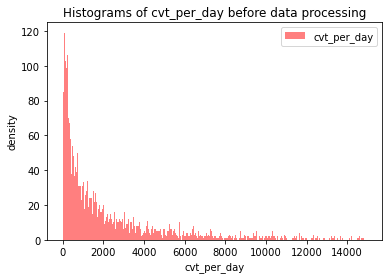

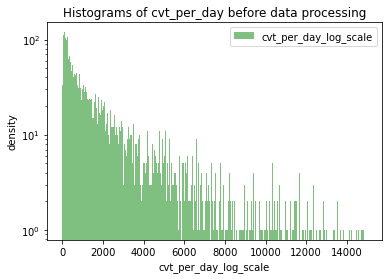

In [20]:
# cvt_per_day data explore
plt.hist(TV['cvt_per_day'].values, bins = range(0,15000, 30), alpha = 0.5, color='r', label = 'cvt_per_day')
plt.legend(loc ='upper right')
plt.title('Histograms of cvt_per_day before data processing')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

# log scale of y due to large variation
plt.hist(TV['cvt_per_day'].values, log = True, bins = range(0,15000, 30), alpha = 0.5, color='g', label = 'cvt_per_day_log_scale')
plt.legend(loc ='upper right')
plt.title('Histograms of cvt_per_day before data processing')
plt.xlabel('cvt_per_day_log_scale')
plt.ylabel('density')
plt.show()

### 1.2.3 Correlation among numerical features

<AxesSubplot:>

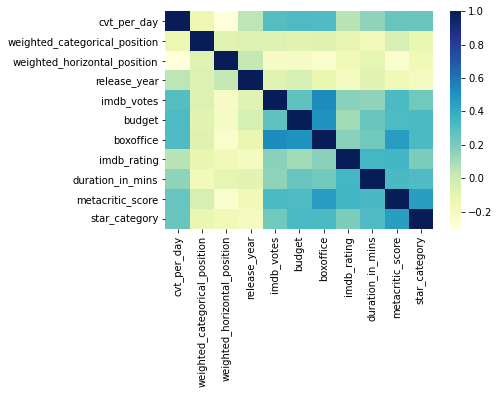

In [21]:
# correlation of the numerical features 
corr = TV[['cvt_per_day','weighted_categorical_position','weighted_horizontal_position'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

## 1.3 Understand the categorical features¶ 
### 1.3.1 simple categorical features (import_id, mpaa, awards)

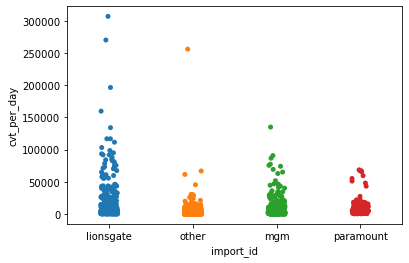

       index  import_id
0      other       2963
1  lionsgate        677
2        mgm        445
3  paramount        141


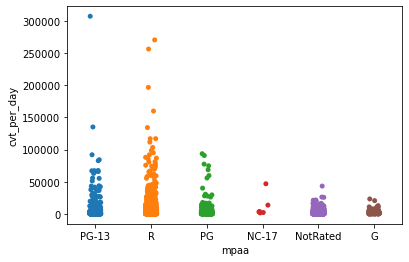

      index  mpaa
0  NotRated  2158
1         R  1158
2     PG-13   426
3        PG   353
4         G   125
5     NC-17     6


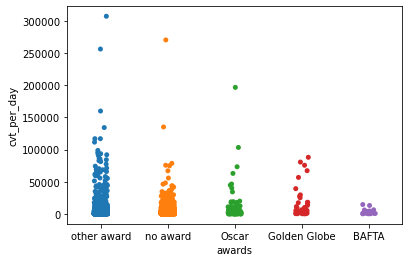

          index  awards
0      no award    2569
1   other award    1453
2         Oscar     141
3  Golden Globe      44
4         BAFTA      19


In [22]:
sns.stripplot(x='import_id', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print (TV['import_id'].value_counts().reset_index())

sns.stripplot(x='mpaa', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print (TV['mpaa'].value_counts().reset_index())

sns.stripplot(x='awards', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print (TV['awards'].value_counts().reset_index())

### 1.3.2 Distribution of splited genres
Some videos belongs to more than 1 genre, the genre of each video is splited, this would help emphasize the effect of each individual genre.

In [26]:
TV['genres'].head()

0                            Action,Thriller,Drama
1                            Comedy,Crime,Thriller
2                                      Crime,Drama
3    Thriller,Drama,War,Documentary,Mystery,Action
4               Crime,Thriller,Mystery,Documentary
Name: genres, dtype: object

<AxesSubplot:>

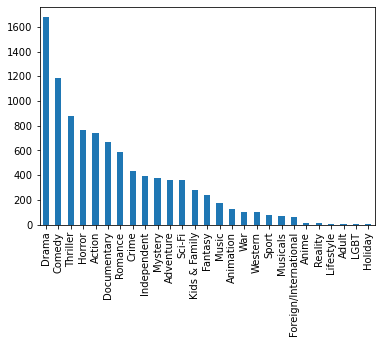

In [36]:
# genres explore, split the genre of each video
gen_split = TV['genres'].str.get_dummies(sep=',').sum()
gen_split.sort_values(ascending=False).plot.bar()

6 genres including Anime, Reality, Lifestyle, Adult, LGBT, Holiday have low frequencies. Therefore, during feature processing, they will be grouped together as: 'Misc_gen' in the feature 'genres'.

### 1.3.3 Distribution of release_year
The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketed based on the release_year range. 

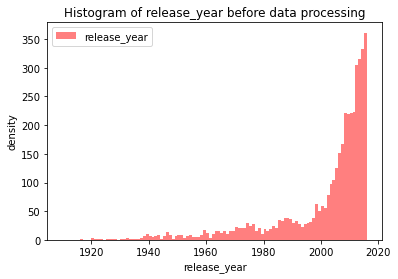

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
20%     1991.000
30%     2001.000
40%     2006.000
50%     2008.000
60%     2010.000
70%     2012.000
80%     2013.000
90%     2014.000
max     2017.000
Name: release_year, dtype: float64


In [38]:
plt.figure(1)
plt.hist(TV['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Histogram of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()

print (TV['release_year'].describe(percentiles = [.1, .2, .3, .4,.5, .6, .7, .8, .9]))

# Part 2: Feature Preprocessing

## 2.1 Categorical features
There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 1. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

The release_year is bined into 10 buckets based on the year range between 1917 and 2017.

In [39]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(TV['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(TV['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(TV['awards']).astype(np.int64)

In [51]:
# Convert 'genres' into dummy variables
d_genres = TV['genres'].str.get_dummies(sep=',')

# combine 6 smallest genres into a new genre 'Misc_gen'. Use bitwise operation '|', then drop these 6 columns.
d_genres['Misc_gen'] = d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [53]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014,2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(TV['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [61]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null
TV_temp = TV.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)
newTV = pd.concat([TV_temp, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
print (newTV.shape)
print (pd.isnull(newTV).any(1).sum())
newTV_0 = newTV.copy() # a copy of newTV

(4226, 58)
0


Feature space holds 4226 observations and 58 features in total.

There is NO null data. newTV_0 is kepted as the raw dataframe before any further feature processing, e.g. replace 0 with null, missing data fill etc. 

## 2.2 Handling of missing data 
Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.

In [67]:
# mark zero values as NaN
newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)

#count the number videos who have at least one missing data 
print ('videos having at least one null: ', newTV.isnull().any(axis=1).sum())

# count the number of NaN values in each column
print (newTV.isnull().sum())

videos having at least one null:  3242
video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_position        0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
star_category                    1846
lionsgate                           0
mgm                                 0
other                               0
paramount                           0
G                                   0
NC-17                               0
NotRated                            0
PG                                  0
PG-13                               0
R                                   0
BAFTA                               0
Golden Globe                        0
Oscar                               0
no award                            0
other award

### 2.2.1 Filling missing data with mean value
For imdb_voates and imdb_rating, they always show 'null' together, which is reasonable, since when a imdb_votes is missing, the imdb_rating is mostly also missing. For all 6 features with missiong data, the 1st attempt is to fill in with their mean value.

In [68]:
# fill missing values with the column mean
newTV_i1 = newTV.copy()
newTV_i1['budget'].fillna(newTV_i1['budget'].mean(), inplace=True)
newTV_i1['boxoffice'].fillna(newTV_i1['boxoffice'].mean(), inplace=True)
newTV_i1['metacritic_score'].fillna(newTV_i1['metacritic_score'].mean(), inplace=True)
newTV_i1['star_category'].fillna(newTV_i1['star_category'].mean(), inplace=True)
newTV_i1['imdb_votes'].fillna(newTV_i1['imdb_votes'].mean(), inplace=True)
newTV_i1['imdb_rating'].fillna(newTV_i1['imdb_rating'].mean(), inplace=True)

newTV_i1 have the feature processing as: fill the missing data in budget, boxoffice, metacritic_score, star_category, imdb_votes, imdb_rating with mean. It will be tested in the upcoming models. 

### 2.2.1 Filling missing data by linear regression

#### 2.2.1 Filling in imbd_votes by linear regression

In [70]:
newTV_i2 = newTV.copy()
newTV_i2['budget'].fillna(newTV_i1['budget'].mean(), inplace=True)
newTV_i2['boxoffice'].fillna(newTV_i1['boxoffice'].mean(), inplace=True)
newTV_i2['metacritic_score'].fillna(newTV_i1['metacritic_score'].mean(), inplace=True)
newTV_i2['star_category'].fillna(newTV_i1['star_category'].mean(), inplace=True)
#newTV_i1['imdb_votes'].fillna(newTV_i1['imdb_votes'].mean(), inplace=True)
newTV_i2['imdb_rating'].fillna(newTV_i1['imdb_rating'].mean(), inplace=True)
#newTV_i2.isnull().sum()

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# index of non-null index for imdb_votes
votes_index = np.where(newTV_i2['imdb_votes'].notnull())[0]
# index of null index for imdb_votes
votes_null_index = np.where(newTV_i2['imdb_votes'].isnull())[0]

votes_all = pd.DataFrame(newTV_i2, index = list(votes_index), columns = list(newTV_i2))
votes_null = pd.DataFrame(newTV_i2, index = list(votes_null_index), columns = list(newTV_i2))

votes_train, votes_test = train_test_split(votes_all, test_size=0.2, random_state = 0)
votes_train_x = votes_train.drop('imdb_votes', axis = 1)
votes_test_x = votes_test.drop('imdb_votes', axis = 1)
votes_train_y = votes_train['imdb_votes']
votes_test_y = votes_test['imdb_votes']



The optimized alpha and score of Lasso linear is:  359.38136638046257 0.5196374112027902


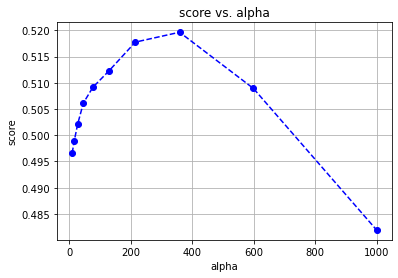

In [71]:

alphas = np.logspace(1, 3, 10)
#print (alphas)
scores = np.empty_like(alphas)
#print (scores)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = linear_model.Lasso()
    lasso.set_params(alpha =a)
    lasso.fit(votes_train_x, votes_train_y)
    scores[i] = lasso.score(votes_test_x, votes_test_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
print  ('The optimized alpha and score of Lasso linear is: ', opt_a, max_score)
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()

In [97]:
# predict the missing values with best alpha and fill in the missing values
lasso_fillNan = linear_model.Lasso()
lasso_fillNan.set_params (alpha = opt_a)
lasso_fillNan.fit(votes_train_x, votes_train_y)
pred_null = lasso_fillNan.predict(votes_null.drop('imdb_votes', axis = 1)).astype('int64')
#print newTV_i2.isnull().sum()
newTV_i2.loc [votes_null_index, 'imdb_votes'] = pred_null
#print newTV_i2.isnull().sum()

#### 2.2.1 Filling in imbd_ratings by linear regression

## 2.3 Feature scaling
The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used. 

In [99]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_position', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newTV_sc = newTV_i2.copy()

sc_scale = preprocessing.StandardScaler().fit(newTV_sc[scale_lst])
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])

newTV_sc.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.994,1.470,4.696,0.542,1.079,-0.630,...,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.271,1.470,-1.022,0.542,0.257,-1.997,...,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.034,3.108,3.898,1.100,1.243,0.327,...,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.045,1.470,0.767,1.309,1.952,5.250,...,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.271,3.290,-0.265,0.472,0.758,-2.544,...,0,0,0,0,0,0,0,1,0,0


In [100]:
# MinMax scaling
newTV_mm = newTV_i2.copy()
mm_scale = preprocessing.MinMaxScaler().fit(newTV_mm[scale_lst])
newTV_mm[scale_lst] = mm_scale.transform(newTV_mm[scale_lst])

In [101]:
# Robust scaling
newTV_rs = newTV_i2.copy()
rs_scale = preprocessing.RobustScaler().fit(newTV_mm[scale_lst])
newTV_rs[scale_lst] = rs_scale.transform(newTV_rs[scale_lst])

# Part 3: Model Training 

85% of the samples will be used to train all the models, and 15% is reserved for test the models in next section.

In [102]:
# The 15% test data will kept aside, they won't be seen by the models until final test/comparison.
from sklearn.model_selection import train_test_split

model_train, model_test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = model_test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

## 3.1 Linear models

###  3.1.1 Lasso linear regression
#### 1) All featuers are linear

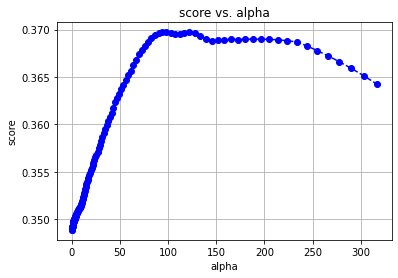

The optimized alpha and score of Lasso linear is:  122.06107238906554 0.3697208156120857


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace (-0.3, 2.5, num=150)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimized alpha and score of Lasso linear is: ', opt_a, max_score)

In [104]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

# lasso_f is the Lasso model (linear feature), to be tested with final test data.

Lasso(alpha=122.06107238906554)

#### 2) Ploynomial features

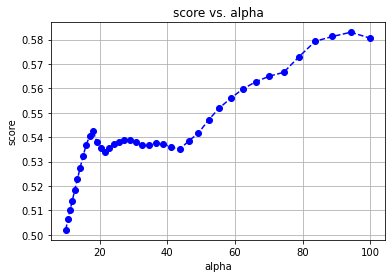

The optimized alpha and score of Lasso polynomial is:  94.26684551178855 0.5829987114296402


Lasso(alpha=94.26684551178855)

In [105]:
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

# lr_train_xp = pd.DataFrame(data=lr_train_xp, index=data[:], columns=data[0,1:]) 

alphas = np.logspace (1, 2, num=40)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_xp, lr_train_y)
    scores[i] = lasso.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimized alpha and score of Lasso polynomial is: ', opt_a, max_score)

# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

In [106]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

Lasso(alpha=94.26684551178855)

### 3.1.2 Ridge linear regression
#### 1) All featuers are linear

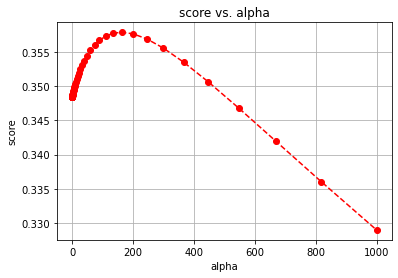

0.35786551312470927 163.97026580002054


In [107]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)

scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print (max_score, opt_a)


In [120]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=14.38449888287663)

#### 2) Polynomial featuers

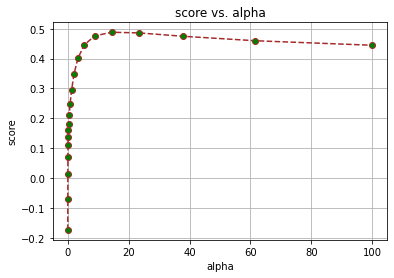

0.48801718480887657 14.38449888287663


In [109]:
# Use the same training data set as Lasso (polynomial features)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)

alphas = np.logspace (-2, 2, num=20)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_xp, lr_train_y)
    scores[i] = ridge.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
        
plt.plot(alphas, scores, color='brown', linestyle='dashed', marker='o',markerfacecolor='g', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print (max_score, opt_a)



In [110]:
# add the 15% validate data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

ridge_fp = Ridge()
ridge_fp.set_params(alpha = opt_a)
ridge_fp.fit(lr_train_xp1, model_train_y)

# ridge_fp is the Ridge model (polynomial feature), to be tested with test data.

Ridge(alpha=14.38449888287663)

## 3.2: Non-linear model
Random forest with Gridsearch cross-validation is used. The 'mean_scores' is used to narrow down the paramenters of n_estimator (number of trees in the forest) and Max_depth (maximum depth of the tree).

### Random forest

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

rf_train, rf_test = train_test_split(model_train, test_size=0.15, random_state = 0)

rf_train_x = rf_train.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_test_x = rf_test.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_train_y = rf_train['cvt_per_day']
rf_test_y = rf_test['cvt_per_day']

param_grid = {
                 'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62],
                 'max_depth': [12, 13, 14, 15, 16, 17]
             }

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt')
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(rf_train_x, rf_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=2),
             param_grid={'max_depth': [12, 13, 14, 15, 16, 17],
                         'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62]})

In [112]:
grid_rf.best_params_

{'max_depth': 16, 'n_estimators': 55}

In [113]:
grid_rf.cv_results_

{'mean_fit_time': array([0.17556987, 0.17541852, 0.18863797, 0.1838706 , 0.18253846,
        0.18430896, 0.19407592, 0.19501333, 0.18446889, 0.18686337,
        0.18914633, 0.22123179, 0.23332491, 0.20409064, 0.20294228,
        0.20681081, 0.18930397, 0.19303899, 0.19647818, 0.20030317,
        0.20359674, 0.20706058, 0.21256943, 0.2185595 , 0.2058898 ,
        0.20258455, 0.20638638, 0.21094289, 0.21334085, 0.21688309,
        0.22068992, 0.22806954, 0.20814447, 0.21193995, 0.21595469,
        0.21958961, 0.22303023, 0.22646456, 0.23114686, 0.23847156,
        0.21529212, 0.2189939 , 0.22336297, 0.22763553, 0.23122473,
        0.23484359, 0.239252  , 0.24731584]),
 'std_fit_time': array([0.00249631, 0.00215561, 0.02036102, 0.00956792, 0.00126552,
        0.00100276, 0.01268999, 0.00150714, 0.00436445, 0.00148701,
        0.00228472, 0.04239869, 0.06220366, 0.00705376, 0.0012935 ,
        0.00186329, 0.00080928, 0.00076711, 0.00101009, 0.00080909,
        0.00114262, 0.00076548, 0.004

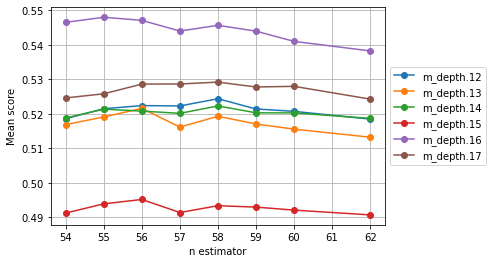

In [114]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 


scores = [x for x in grid_rf.cv_results_['mean_test_score']]

n_est = [54, 55, 56, 57, 58, 59, 60, 62]
m_depth=[12, 13, 14, 15, 16, 17]


scores = np.array(scores).reshape(len(m_depth), len(n_est))

fig = plt.figure()
ax = plt.subplot(111)
for ind, i in enumerate(m_depth):
    plt.plot(n_est, scores[ind], '-o', label='m_depth.' + str(i),)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('n estimator')
plt.ylabel('Mean score')
plt.grid(True)
plt.show()
# savefig('rf_1')

In [116]:
# add both training and validation data together as the new training data
rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 16, n_estimators=55)
rf.fit(model_train_x, model_train_y)

RandomForestRegressor(max_depth=16, max_features='sqrt', n_estimators=55,
                      random_state=2)

The best rf model have n_estimator = 16, and max_depth = 55.

# Part 4: Model Evaluation
Test data is the reserved 15% of the whole dataset, and has never been seen by the above models. 

## 4.1 Lasso test with linear features (lasso_f)

In [117]:
# Lasso_f test (with linear features)

lasso_f_score = lasso_f.score(model_test_x, model_test_y)
pred_y = lasso_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_lasso_f = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('lasso_f score: ', lasso_f_score)
print ('Mean square error of lasso_f: ', MSE_lasso_f)
print ('Root mean squared error of lasso_f:', RMSE_lasso_f)
# print ('Coefficients of lasso_f: ', lasso_f.coef_)

lasso_f score:  0.09263234449657709
Mean square error of lasso_f:  240788741.4669559
Root mean squared error of lasso_f: 15517.369025287628


## 4.2 Lasso test with polynomial features (lasso_fp)

In [118]:
# Lasso_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)
pred_y = lasso_fp.predict(model_test_xp)

lasso_fp_score = lasso_fp.score(model_test_xp, model_test_y)
MSE_lasso_fp = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_fp = sqrt(mean_squared_error(model_test_y, pred_y))

print ('lasso_fp score: ', lasso_fp_score)
print ('Mean square error of lasso_fp: ', MSE_lasso_fp)
print ('Root mean squared error of lasso_fp:', RMSE_lasso_fp)
# print ('Coefficients of lasso_fp: ', lasso_fp.coef_)

lasso_fp score:  0.15295073547573268
Mean square error of lasso_fp:  224782011.04947755
Root mean squared error of lasso_fp: 14992.731940826447


## 4.3 Ridge test with linear features (ridge_f)

In [121]:
# ridge_f test (with linear features)

ridge_f_score = ridge_f.score(model_test_x, model_test_y)
pred_y = ridge_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_ridge_f = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('ridge_f score: ', ridge_f_score)
print ('Mean square error of ridge_f: ', MSE_ridge_f)
print ('Root mean squared error of ridge_f:', RMSE_ridge_f)
# print ('Coefficients of ridge_f: ', ridge_f.coef_)

ridge_f score:  0.10551693359018022
Mean square error of ridge_f:  237369549.72769752
Root mean squared error of ridge_f: 15406.802060378965


## 4.4 Ridge test with polynomial features (ridge_fp)

In [122]:
# ridge_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)

ridge_fp_score = ridge_fp.score(model_test_xp, model_test_y)
MSE_ridge_fp = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_fp = sqrt(mean_squared_error(model_test_y, pred_y))

pred_y = ridge_fp.predict(model_test_xp)
print ('ridge_fp score: ', ridge_f_score)
print ('Mean square error of ridge_fp: ', MSE_ridge_fp)
print ('Root mean squared error of ridge_fp:', RMSE_ridge_fp)
#print ('Coefficients of ridge_fp: ', ridge_fp.coef_)

ridge_fp score:  0.10551693359018022
Mean square error of ridge_fp:  237369549.72769752
Root mean squared error of ridge_fp: 15406.802060378965


## 4.5 Random forest test (rf)

In [123]:
rf_score = rf.score(model_test_x, model_test_y)

pred_y = rf.predict(model_test_x)
MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.5042990673210334
Mean square error of rf:  131544477.03730646
Root mean squared error of rf: 11469.284068210467


## 4.6 Comparison of the 5 models
Compared the max_score, mean squared error (MSE), and root mean squared error (RMSE) of 5 models. Random forest model rf returns the beset prediction accuracy.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


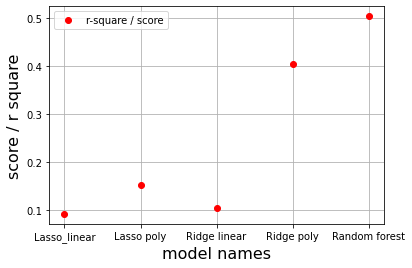

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


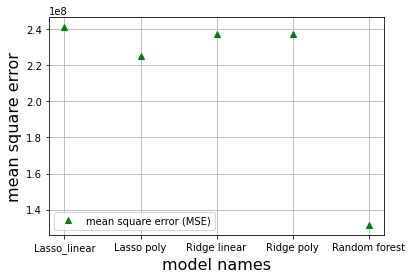

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


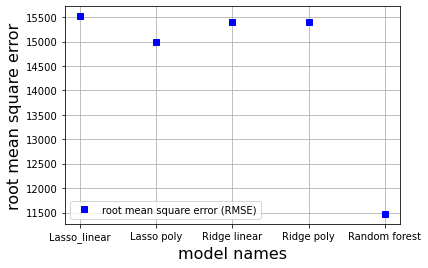

In [124]:
lst_score = [lasso_f_score, lasso_fp_score, ridge_f_score, ridge_fp_score, rf_score]
MSE_lst =  [MSE_lasso_f, MSE_lasso_fp, MSE_ridge_f, MSE_ridge_fp, MSE_rf]
RMSE_lst =  [RMSE_lasso_f, RMSE_lasso_fp, RMSE_ridge_f, RMSE_ridge_fp, RMSE_rf]
model_lst = ['Lasso_linear','Lasso poly', 'Ridge linear', 'Ridge poly', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(loc = 9)
plt.legend(['r-square / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()


# 5. Feature importance
Random forest(RF) shows the best prediction accuracy. Therefore, the feature importance will be extracted from the RF model. 

Feature importance ranking:
1. feature 2 weighted_categorical_position (0.146195)
2. feature 0 weighted_horizontal_position (0.115427)
3. feature 1 imdb_votes (0.110858)
4. feature 7 budget (0.070222)
5. feature 3 boxoffice (0.065554)
6. feature 8 imdb_rating (0.056250)
7. feature 4 duration_in_mins (0.052151)
8. feature 9 metacritic_score (0.044754)
9. feature 6 star_category (0.042139)
10. feature 5 lionsgate (0.032824)
11. feature 11 mgm (0.031813)
12. feature 52 other (0.022400)
13. feature 53 paramount (0.018457)
14. feature 10 G (0.012920)
15. feature 18 NC-17 (0.011925)
16. feature 42 NotRated (0.011176)
17. feature 28 PG (0.010977)
18. feature 30 PG-13 (0.010055)
19. feature 49 R (0.007745)
20. feature 22 BAFTA (0.007736)
21. feature 27 Golden Globe (0.007643)
22. feature 48 Oscar (0.006846)
23. feature 50 no award (0.006157)
24. feature 47 other award (0.005860)
25. feature 29 Action (0.005751)
26. feature 23 Adventure (0.005703)
27. feature 24 Animation (0.005681)
28. feature

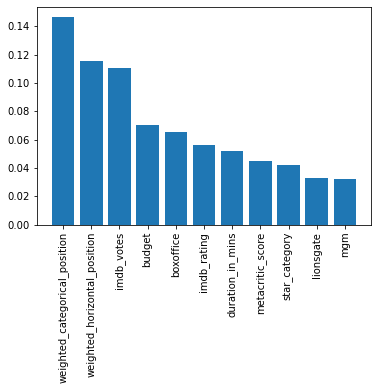

In [126]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = model_test_x.columns

# Print the feature ranking
print("Feature importance ranking:")

for f in range(model_test_x.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],  feature_name[f], importances[indices[f]]))
    
plt.figure(1)
plt.bar(feature_name[:11], importances[indices[:11]])
plt.xticks(rotation=90)
plt.show()

# Conclusion
After trying linear Lasso Regression,  Polynomial Lasso Regression, Ridge, Linear Ridge Regression and  Polynomial  Ridge Regression, and Random Forest, I found that random forest has the best accuracy rate and lowest mean square error. The top predictive features of movies' popularity are weighted_categorical_position, weighted horizontal_position, and imbd_votes.